In [2]:
import torch
import numpy as np
import pandas as pd
import networkx as nx
from tqdm import tqdm
import pickle
import sys, os
import requests
from torch_geometric.data import Data
from zipfile import ZipFile
import tarfile
from sklearn.linear_model import TheilSenRegressor
from dcor import distance_correlation
from multiprocessing import Pool

In [ ]:
def get_coexpression_network_from_train(adata, threshold, k, data_path,
                                        data_name, split, seed, train_gene_set_size,
                                        set2conditions):
    """
    Infer co-expression network from training data

    Args:
        adata (anndata.AnnData): anndata object
        threshold (float): threshold for co-expression
        k (int): number of edges to keep
        data_path (str): path to data
        data_name (str): name of dataset
        split (str): split of dataset
        seed (int): seed for random number generator
        train_gene_set_size (int): size of training gene set
        set2conditions (dict): dictionary of perturbations to conditions
    """
    
    fname = os.path.join(os.path.join(data_path, data_name), split + '_'  +
                         str(seed) + '_' + str(train_gene_set_size) + '_' +
                         str(threshold) + '_' + str(k) +
                         '_co_expression_network.csv')
    
    if os.path.exists(fname):
        return pd.read_csv(fname)
    else:
        gene_list = [f for f in adata.var.gene_name.values]
        idx2gene = dict(zip(range(len(gene_list)), gene_list)) 
        X = adata.X
        train_perts = set2conditions['train']
        X_tr = X[np.isin(adata.obs.condition, [i for i in train_perts if 'ctrl' in i])]
        gene_list = adata.var['gene_name'].values

        X_tr = X_tr.toarray()
        out = np_pearson_cor(X_tr, X_tr)
        out[np.isnan(out)] = 0
        out = np.abs(out)

        out_sort_idx = np.argsort(out)[:, -(k + 1):]
        out_sort_val = np.sort(out)[:, -(k + 1):]

        df_g = []
        for i in range(out_sort_idx.shape[0]):
            target = idx2gene[i]
            for j in range(out_sort_idx.shape[1]):
                df_g.append((idx2gene[out_sort_idx[i, j]], target, out_sort_val[i, j]))

        df_g = [i for i in df_g if i[2] > threshold]
        df_co_expression = pd.DataFrame(df_g).rename(columns = {0: 'source',
                                                                1: 'target',
                                                                2: 'importance'})
        df_co_expression.to_csv(fname, index = False)
        return df_co_expression

In [16]:
def np_pearson_cor(x, y):
    xv = x - x.mean(axis=0)
    yv = y - y.mean(axis=0)
    xvss = (xv * xv).sum(axis=0)
    yvss = (yv * yv).sum(axis=0)
    result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
    # bound the values to -1 to 1 in the event of precision issues
    return np.maximum(np.minimum(result, 1.0), -1.0)

In [3]:
import os
os.chdir("/gpfs/home/asun/jin_lab/GEARS/demo/")
print(os.getcwd())
import sys
sys.path.append(os.path.abspath('..'))

from gears import PertData, GEARS

/gpfs/group/jin/asun/GEARS/demo


/gpfs/home/asun/miniforge3/envs/gears/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/gpfs/home/asun/miniforge3/envs/gears/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/gpfs/home/asun/miniforge3/envs/gears/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/gpfs/home/asun/miniforge3/envs/gears/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/gpfs/home/asun/miniforge3/envs/gears/lib/python3.12/site-packages/anndata/utils.py:434: Futur

In [4]:
pert_data = PertData('/gpfs/home/asun/jin_lab/GEARS/demo/data') # specific saved folder
pert_data.load(data_path = '/gpfs/home/asun/jin_lab/GEARS/demo/data/zheng') # load the processed data, the path is saved folder + dataset_name
pert_data.prepare_split(split = 'simulation_single', seed = 1) # get data split with seed
pert_data.get_dataloader(batch_size = 32, test_batch_size = 128) # prepare data loader

Found local copy...


Found local copy...
These perturbations are not in the GO graph and their perturbation can thus not be predicted
[]
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Done!
Creating dataloaders....
Done!


here1


In [4]:
pert_data.set2conditions

{'test': ['NR2F1+ctrl'],
 'train': ['ctrl', 'TCF4+ctrl', 'FOXG1+ctrl'],
 'val': ['TBR1+ctrl']}

In [ ]:
  def model_initialize(self, hidden_size = 64,
                         num_go_gnn_layers = 1, 
                         num_gene_gnn_layers = 1,
                         decoder_hidden_size = 16,
                         num_similar_genes_go_graph = 20,
                         num_similar_genes_co_express_graph = 20,                    
                         coexpress_threshold = 0.4,
                         uncertainty = False, 
                         uncertainty_reg = 1,
                         direction_lambda = 1e-1,
                         G_go = None,
                         G_go_weight = None,
                         G_coexpress = None,
                         G_coexpress_weight = None,
                         no_perturb = False,
                         **kwargs
                        ):

In [ ]:
edge_list = get_similarity_network(network_type='co-express',
                                               adata=self.adata,
                                               threshold=coexpress_threshold,
                                               k=num_similar_genes_co_express_graph,
                                               data_path=self.data_path,
                                               data_name=self.dataset_name,
                                               split=self.split, seed=self.seed,
                                               train_gene_set_size=self.train_gene_set_size,
                                               set2conditions=self.set2conditions)

In [ ]:
adata, threshold, k, data_path,
                                        data_name, split, seed, train_gene_set_size,
                                        set2conditions):

In [6]:
adata = pert_data.adata
threshold = 0.4
k = 20
data_path = pert_data.data_path
data_name = pert_data.dataset_name
split = pert_data.split
seed = pert_data.seed
train_gene_set_size = pert_data.train_gene_set_size
set2conditions = pert_data.set2conditions


In [7]:
gene_list = [f for f in adata.var.gene_name.values]


In [9]:
print([i for i in train_perts if 'ctrl' in i])

['ctrl', 'TCF4+ctrl', 'FOXG1+ctrl']


In [8]:
gene_list = [f for f in adata.var.gene_name.values]
idx2gene = dict(zip(range(len(gene_list)), gene_list)) 
X = adata.X
train_perts = set2conditions['train']
X_tr = X[np.isin(adata.obs.condition, [i for i in train_perts if 'ctrl' in i])]
gene_list = adata.var['gene_name'].values

In [14]:
X.shape

(10361, 5000)

In [13]:
X_tr.shape

(7028, 5000)

In [18]:
#X_tr = X_tr.toarray()
out = np_pearson_cor(X_tr, X_tr)
out[np.isnan(out)] = 0
out = np.abs(out)

In [20]:
out.shape

(5000, 5000)

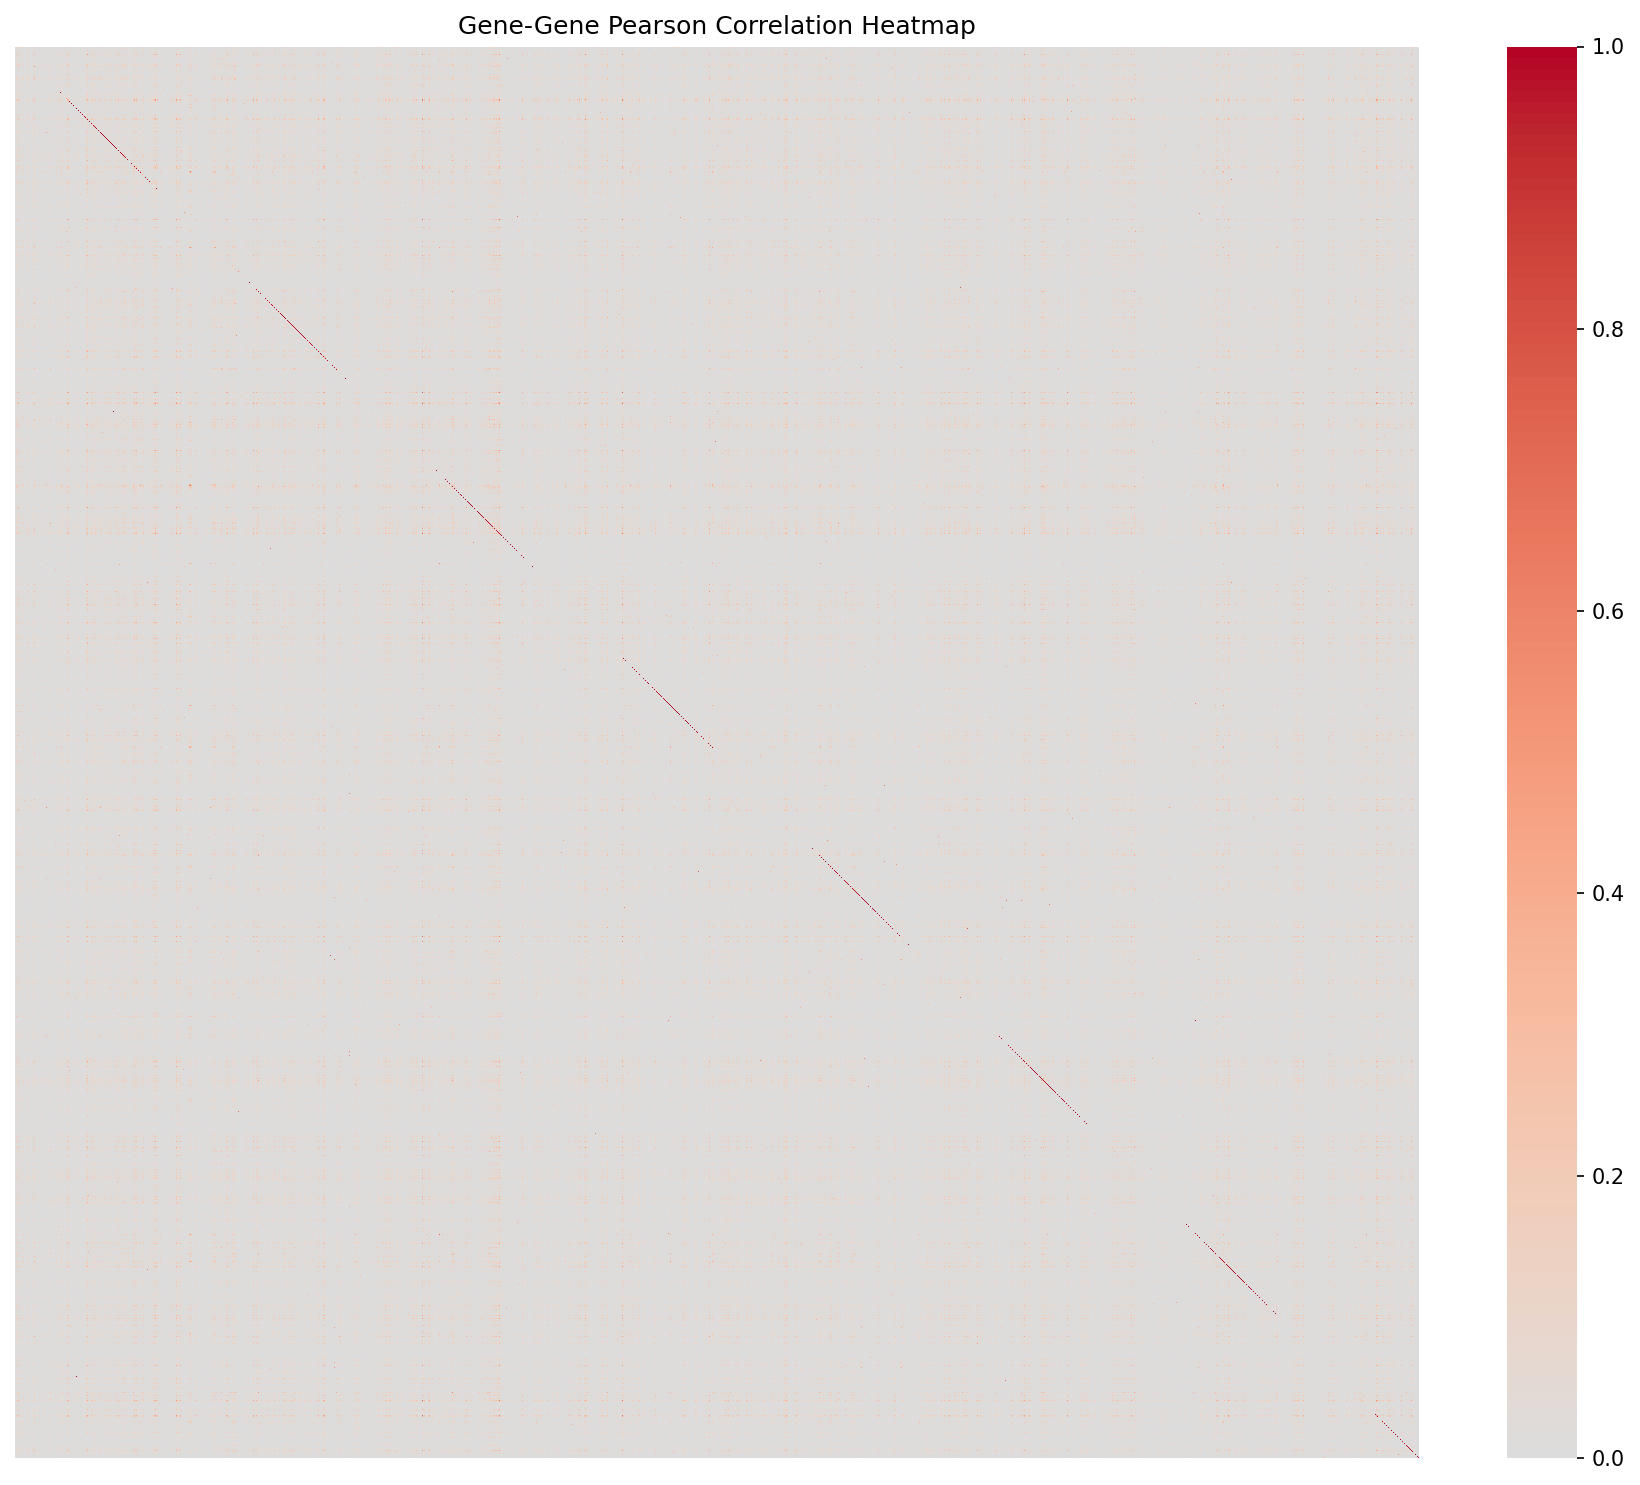

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 10), dpi=150)  # adjust size/DPI for clarity
sns.heatmap(out, cmap='coolwarm', center=0, cbar=True, xticklabels=False, yticklabels=False)
plt.title("Gene-Gene Pearson Correlation Heatmap")
plt.tight_layout()
plt.show()

In [21]:
out_sort_idx = np.argsort(out)[:, -(k + 1):]
out_sort_val = np.sort(out)[:, -(k + 1):]

In [23]:
df_g = []
for i in range(out_sort_idx.shape[0]):
    target = idx2gene[i]
    for j in range(out_sort_idx.shape[1]):
        df_g.append((idx2gene[out_sort_idx[i, j]], target, out_sort_val[i, j]))


In [24]:
df_g_filtered = [i for i in df_g if i[2] > threshold]
df_co_expression = pd.DataFrame(df_g_filtered).rename(columns = {0: 'source',
                                                        1: 'target',
                                                        2: 'importance'})

In [5]:
node_map = pert_data.node_map
node_map

{'Xkr4': 0,
 'Gm37323': 1,
 'Rgs20': 2,
 'Oprk1': 3,
 'St18': 4,
 'Sntg1': 5,
 'Vxn': 6,
 'Cpa6': 7,
 'Prex2': 8,
 'A830018L16Rik': 9,
 'Sulf1': 10,
 'Eya1': 11,
 'Kcnb2': 12,
 'Terf1': 13,
 'Gm16070': 14,
 'Crispld1': 15,
 'Tfap2d': 16,
 'Tfap2b': 17,
 'Il17f': 18,
 'Mcm3': 19,
 'Efhc1': 20,
 'Tram2': 21,
 'Gsta3': 22,
 'Gm28836': 23,
 'Khdc1b': 24,
 'Kcnq5': 25,
 'B3gat2': 26,
 'Col19a1': 27,
 'Adgrb3': 28,
 'Lgsn': 29,
 'Khdrbs2': 30,
 'Gm5415': 31,
 'Gm37591': 32,
 'Gm28417': 33,
 '1110002O04Rik': 34,
 'Arid5a': 35,
 '4930403P22Rik': 36,
 'Fer1l5': 37,
 'Ankrd23': 38,
 'Gm37020': 39,
 'Cnga3': 40,
 'Lipt1': 41,
 'Gm15457': 42,
 'Gm37707': 43,
 'Npas2': 44,
 'Il1rl2': 45,
 'Gm28175': 46,
 'Pantr1': 47,
 'Pou3f3': 48,
 '8430432A02Rik': 49,
 'Gm29040': 50,
 'Ecrg4': 51,
 'Gm29157': 52,
 'Gm29156': 53,
 'Ercc5': 54,
 'Gulp1': 55,
 'Col3a1': 56,
 'Col5a2': 57,
 'Gm28151': 58,
 'Tmeff2': 59,
 'Myo1b': 60,
 'Gm31812': 61,
 'Stat1': 62,
 '1700019D03Rik': 63,
 'Ormdl1': 64,
 'Stk17b': 65,
 

In [ ]:
default_pert_graph = pert_data.default_pert_graph
default_pert_graph

True

In [9]:
data_path = pert_data.data_path

In [10]:
df_jaccard = pd.read_csv(os.path.join(data_path, 
                                     'go_essential_all/go_essential_all.csv'))

In [11]:
pert_list = pert_data.pert_names.tolist()